# Ultrasounds data augmentation

In [1]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

from src.data.image import Ultrasound, Image
from src.data.data_transforms import Resize, DynamicRangeScaling, Compose
from src.data.us_dataset import UsDataset, split_us_dataset
from src.models.clasifier_model import ImageClassifier
from src.models.classifier_trainer import ClassifierTrainer
from src.options.classifier_options import ClassifierOptions
from src.utils import load_us_data, obtain_histogram

labels = {
        "bladder": 0,
        "bowel": 1,
        "gallbladder": 2,
        "kidney": 3,
        "liver": 4,
        "spleen": 5,
    }
inverse_labels = {label: key for key, label in labels.items()}

data = load_us_data()

## 1. Data Exploration 

Before everything, we must look for a good cone segmentation and save it. It will be used for all images in USnotAI dataset, since all of them have the same orientation.

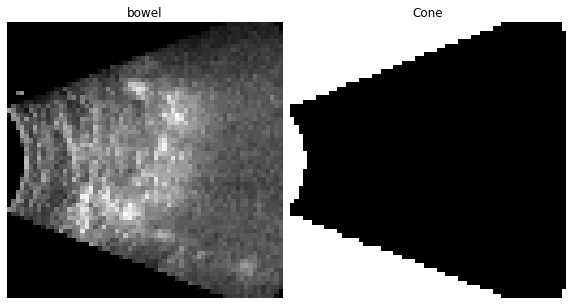

In [2]:
image_number = 5
us = data[image_number]
cone = Image(us.cone_array, "Cone")
f = Image.create_image_grid([us,cone])

This image was selected as cone reference. Results were saved in cone.png. Now, when data is loaded, selected cone is loaded with all images. Now, let's study the dataset statistics

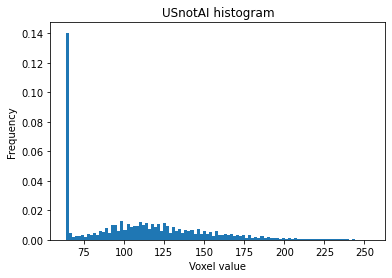

In [4]:
hist = obtain_histogram(data, sample_size=40, title="USnotAI histogram")

## 2. Traininig a classifier for USnotAI

Once we have some insights on the data, we can start training the classification model. It will be the base of all of our work since we need to evaluate ints performance in datasets out of its domain and how data harmonization helps.

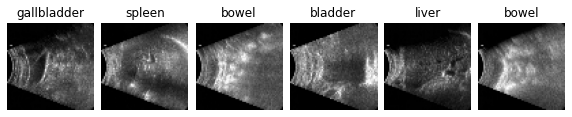

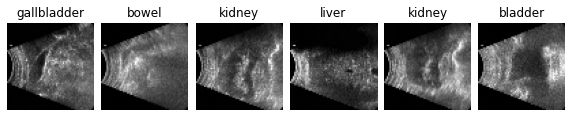

In [2]:

data = load_us_data()
train_data, validation_data = split_us_dataset(data, labels.keys(), 0.2)
f = Ultrasound.create_image_grid(train_data[::50])
f = Ultrasound.create_image_grid(validation_data[::14])

-----------------------MODEL OPTIONS------------------------
Name                     ---->             us_class_try
Device                   ---->                      cpu
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        6
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->             CrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       30
Image_size               ---->                 (64, 64)
Num_threads              ---->                        4
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                 (0, 255)

---------------------Training Epoch: 0----------------------
Running training batch 19/19
Training

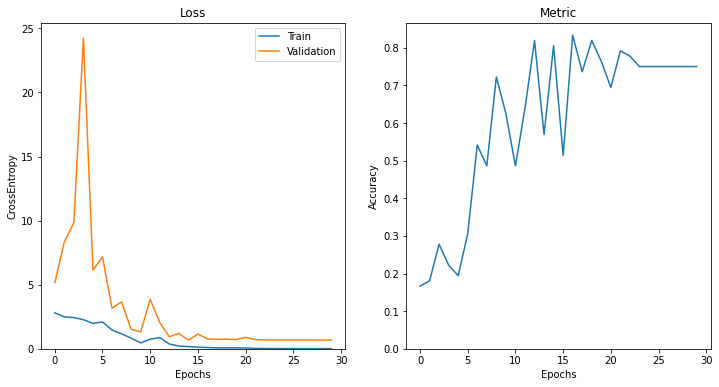

In [3]:
parser = ClassifierOptions()
parser.rewrite_option("name","us_class_try")
parser.rewrite_option("crop_dynamic_range", (0,255))
parser.rewrite_option("n_classes", 6)
parser.rewrite_option("loss_function", "CrossEntropy")
parser.rewrite_option("num_threads", 4)
parser.rewrite_option("epochs", 30)
parser.print_options()

transforms = [
    Resize(parser.image_size),
    DynamicRangeScaling(parser.model_dynamic_range,parser.crop_dynamic_range)
]

train_dataset = UsDataset(train_data, label_dict=labels, transforms=transforms)
validation_dataset = UsDataset(validation_data, label_dict=labels, transforms=transforms)

model = ImageClassifier(parser)
trainer = ClassifierTrainer(model)
trainer.set_dataloaders(train_dataset, validation_dataset)
trainer.train_model()
fig = trainer.plot_losses()



## 3. Let's Play with the model

In [2]:
data = load_us_data()
train_data, validation_data = split_us_dataset(data, labels=labels.keys(), validation_fraction=0.2)
model_path = "saved_models/us_class_try"
parser, model = ImageClassifier.load_pretrained_model(model_path)
transforms = Compose([
    Resize(parser.image_size),
    DynamicRangeScaling(parser.model_dynamic_range, parser.crop_dynamic_range)
])

-----------------------MODEL OPTIONS------------------------
Name                     ---->             us_class_try
Device                   ---->                      cpu
Saved_models_dir         ---->           ./saved_models
Network                  ---->                   resnet
N_classes                ---->                        6
Learning_rate            ---->                    0.001
Threshold                ---->                      0.5
Loss_function            ---->             CrossEntropy
Metric                   ---->                 Accuracy
Epochs                   ---->                       30
Image_size               ---->                 (64, 64)
Num_threads              ---->                        4
Batch_size               ---->                       16
Model_dynamic_range      ---->                  (-2, 2)
Crop_dynamic_range       ---->                 (0, 255)



Text(0.5, 1.0, 'Non altered data')

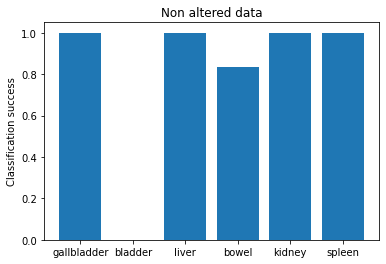

In [17]:


classification_stats = defaultdict(list)
for data in validation_data:
    us = transforms(data.torch_tensor)
    predict = model.inference(us.unsqueeze(0).float())
    success = inverse_labels[predict]==data.label
    classification_stats[data.label].append(int(success))
    if not success:
        #fig = data.plot(f"Real:{data.label} -> Predict:{inverse_labels[predict]}", figsize=(3,3))
        pass

classification_stats = {k: np.mean(v) for k,v in classification_stats.items()}
fig, ax = plt.subplots(1,1)
ax.bar(classification_stats.keys(), classification_stats.values())  
ax.set_ylabel("Classification success")
ax.set_title("Non altered data")
